<a href="https://colab.research.google.com/github/PDDA-OPDU/MICP-Analytics/blob/main/Thomeer_Param_from_KGS_Data/Panel_Bvocc_Thomeer_Parameters_optimization_read_KGS_ver3.ipynb" 
    target="_parent"><img 
    src="https://colab.research.google.com/assets/colab-badge.svg" 
    alt="Open In Colab"/></a>

In [1]:
using_colab = True

In [2]:
if using_colab:


    !wget 'https://github.com/PDDA-OPDU/MICP-Analytics/raw/main/Thomeer_Param_from_KGS_Data/CORE_DATA_AND_DESCRIPTIONS_DATABASE_HPMI_Thomeer.xlsx'
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/STELLA_brief_ver2_backyard_grass_shoreline.ipynb
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_grass_shade_whiteshade.xlsx
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_FullSun.xlsx

    #!pip install altair
    #!pip install panel
    #!pip install pillow
    #!pip install jupyter_bokeh
    #!pip install altair_viewer
    #!pip install altair_transform
    !pip install scipy

    #!unzip photos


# Thomeer fit of HPMI data

## Load Python libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns


import panel as pn

pn.extension(comms='colab')

from scipy.optimize import minimize
from scipy.optimize import curve_fit


# Load Data

## The following cells will load the HPMI data from Kansas Geologic Survey data. 

## 1) Load  row of HPMI data starting at row A12:A130 for Pc and xxx12 to xxx130 for Sw

In [4]:
# Function to convert a number to an Excel-style column letter (supports beyond Z)
def get_column_letter(n):
    result = ""
    while n > 0:
        n, remainder = divmod(n - 1, 26)
        result = chr(65 + remainder) + result
    return result

# Specify the file path and sheet number
file_path = 'CORE_DATA_AND_DESCRIPTIONS_DATABASE_HPMI_Thomeer.xlsx'
sheet_number = 0  # Second sheet, as pandas uses zero-indexing

# Read the Pc values (same for all samples)
pc_values = pd.read_excel(file_path, sheet_name=sheet_number, usecols="A", skiprows=11, nrows=119)

# Initialize a dictionary to store data for each sample
data_dict = {}

# Loop through each sample (from column B onward)
# Adjust the range according to the number of samples we need to process
for sample_num in range(1, 36):  # Example for 51 samples, adjust as necessary
    column_letter = get_column_letter(sample_num + 1)  # +1 because 'B' is column 2
    #print(f"Processing sample {sample_num} (Column {column_letter})")

    # Read Sw values for the current sample
    sw_values = pd.read_excel(file_path, sheet_name=sheet_number, usecols=column_letter, skiprows=11, nrows=119)
    
    # Read Porosity for the current sample (assumed to be in row 8)
    porosity = pd.read_excel(file_path, sheet_name=sheet_number, usecols=column_letter, skiprows=7, nrows=1).iloc[0, 0]
    
    # Read Permeability for the current sample (assumed to be in row 9)
    permeability = pd.read_excel(file_path, sheet_name=sheet_number, usecols=column_letter, skiprows=8, nrows=1).iloc[0, 0]

    # Read Num of Pore systems for the current sample (assumed to be in row 10)
    Num_pore_sys = pd.read_excel(file_path, sheet_name=sheet_number, usecols=column_letter, skiprows=9, nrows=1).iloc[0, 0]
    #print(Num_pore_sys)

    # Store the data in the dictionary
    data_dict[f'Sample_{sample_num}'] = {
        'Pc': pc_values.values.flatten(),
        'Sw': sw_values.values.flatten(),
        'Porosity (%)': porosity,
        'Permeability': permeability,
        'Num_pore_sys': Num_pore_sys,
    }

# Now, data_dict contains the data for all samples, structured for easy access
#print(data_dict)

# Batch 1, 2, or 3 from the spreadsheet
Pc_batch = 1


# 2) Run in Auto Mode:

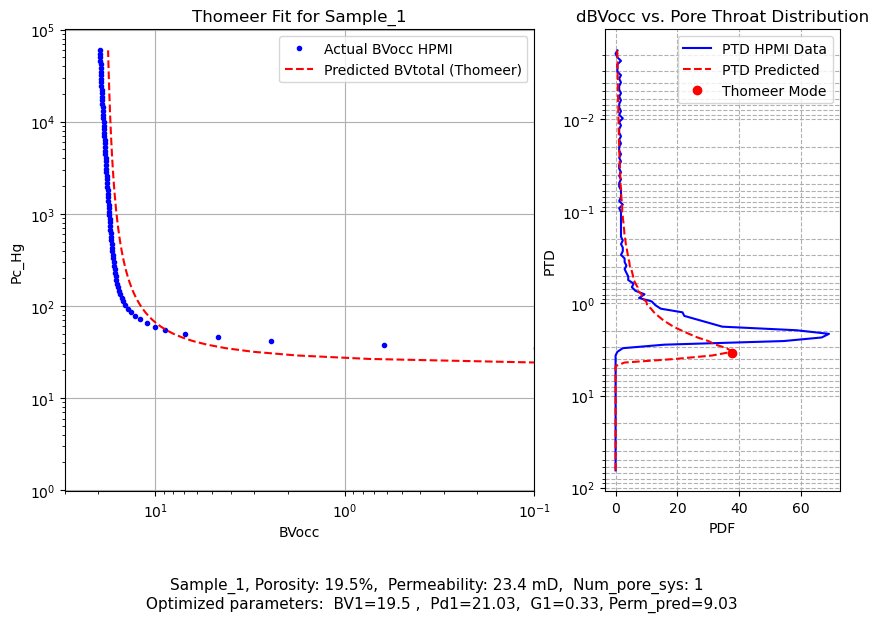

Bad result, optimization error is too high.


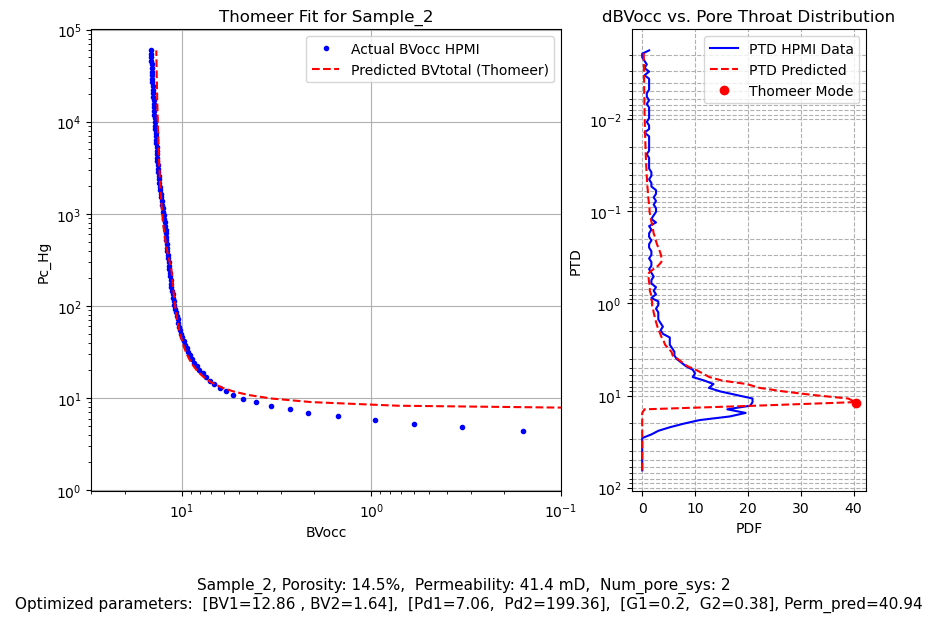

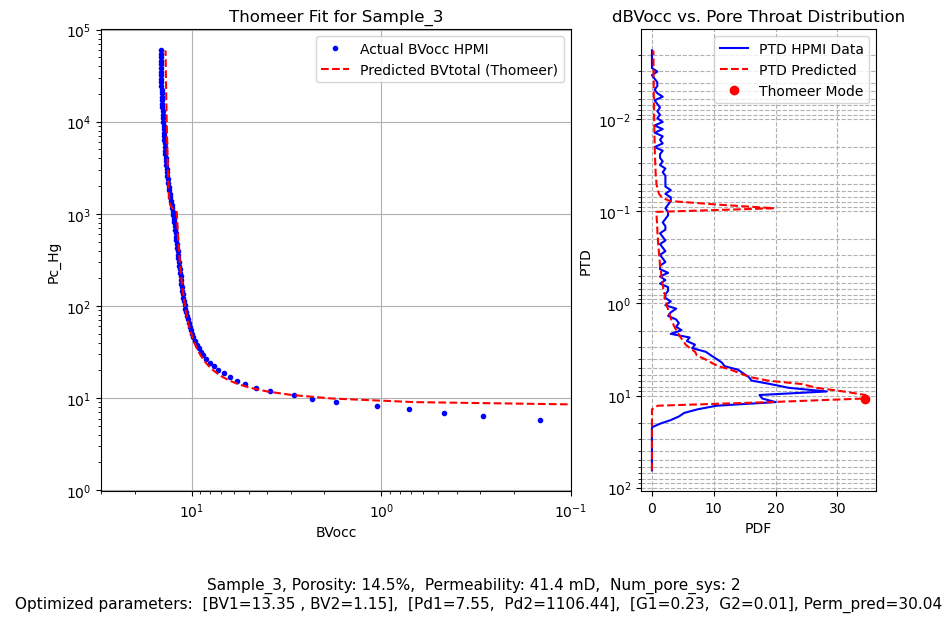

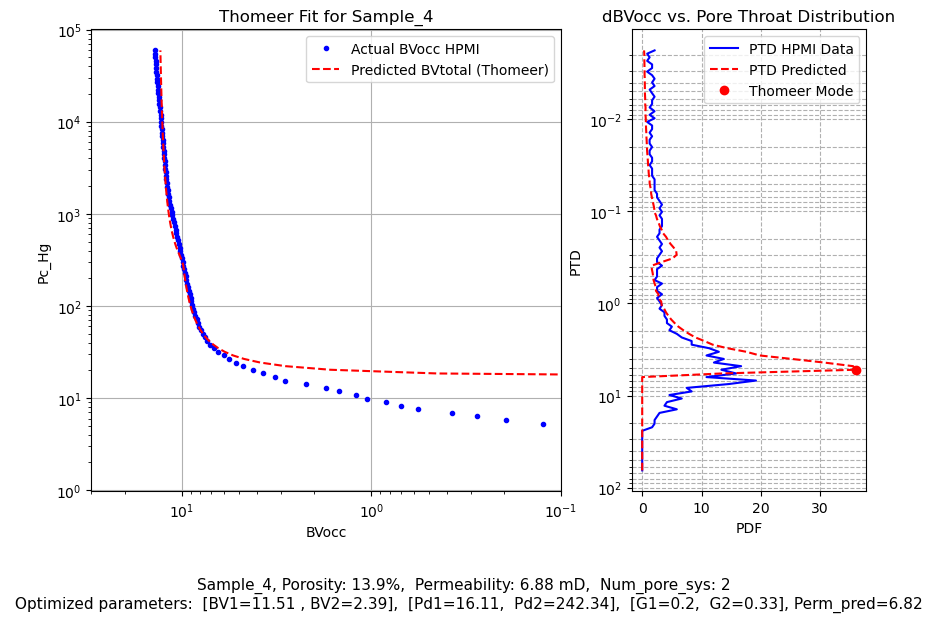

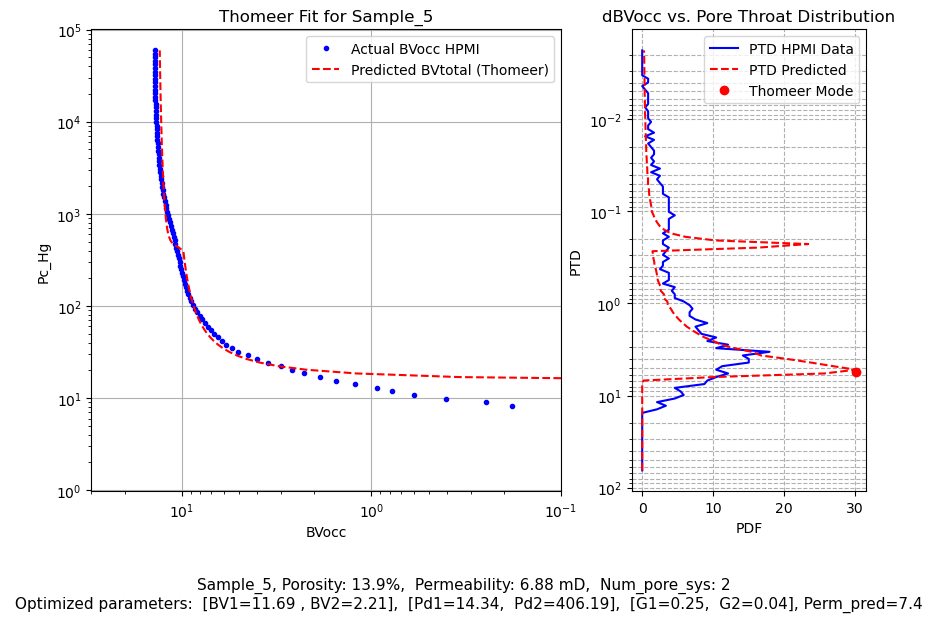

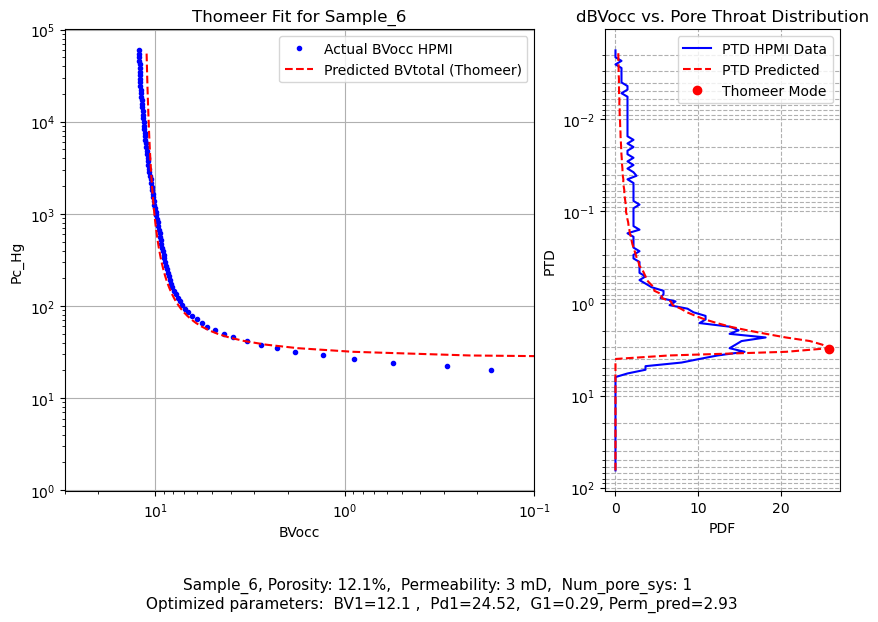

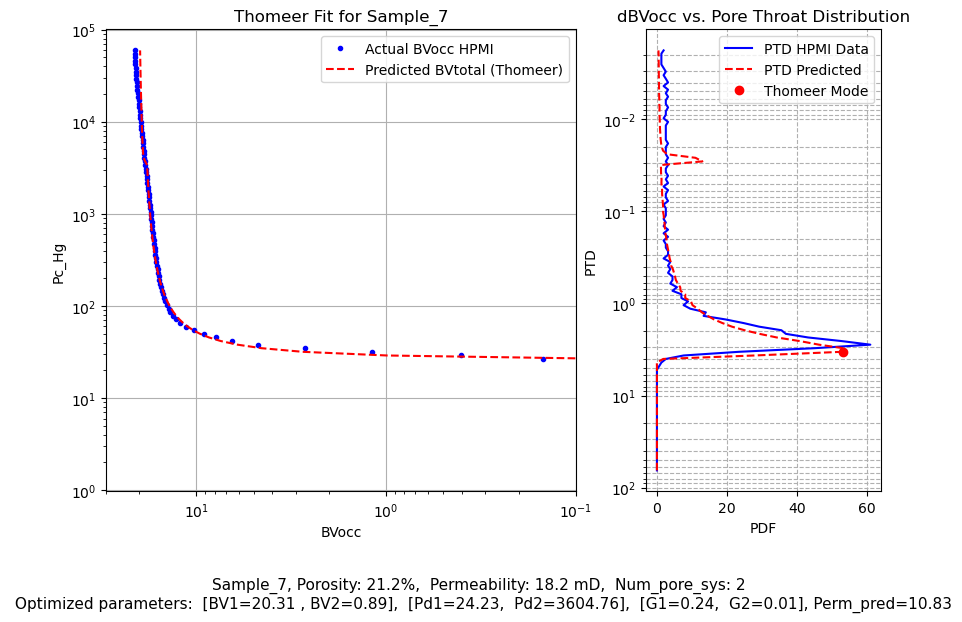

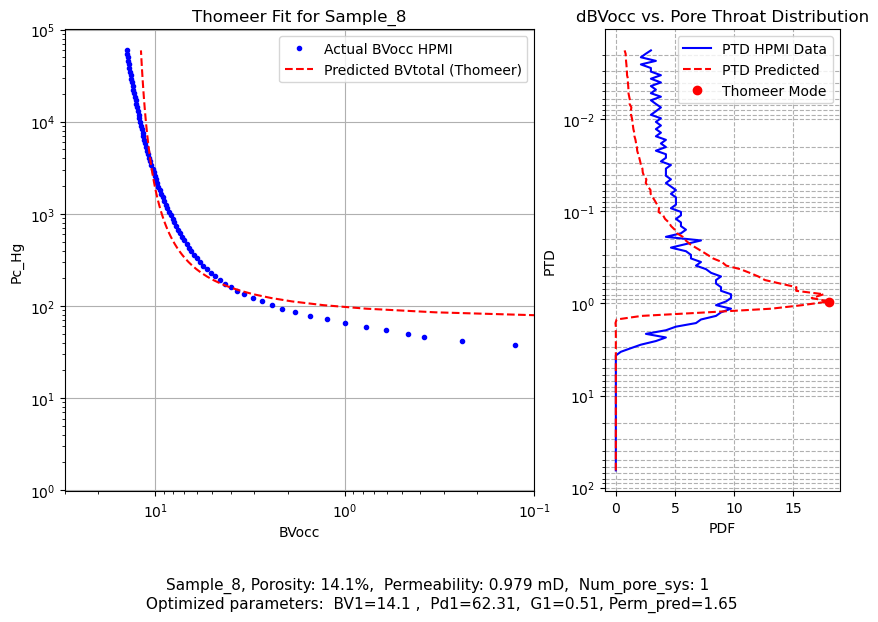

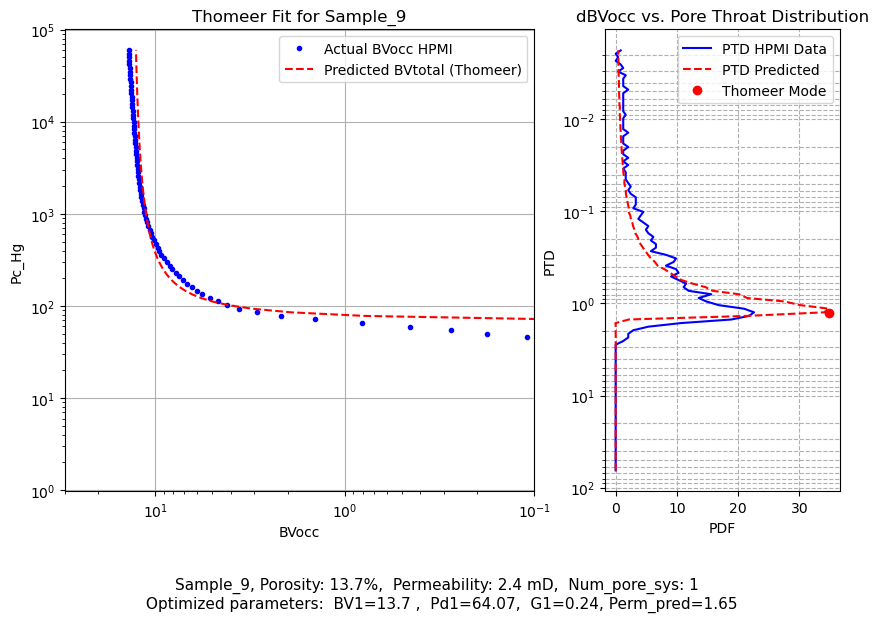

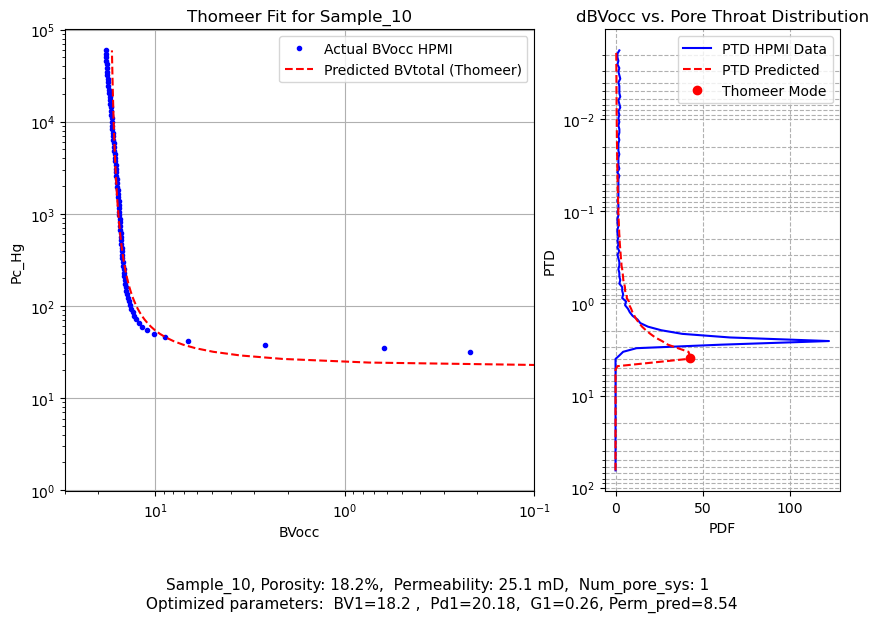

Bad result, optimization error is too high.


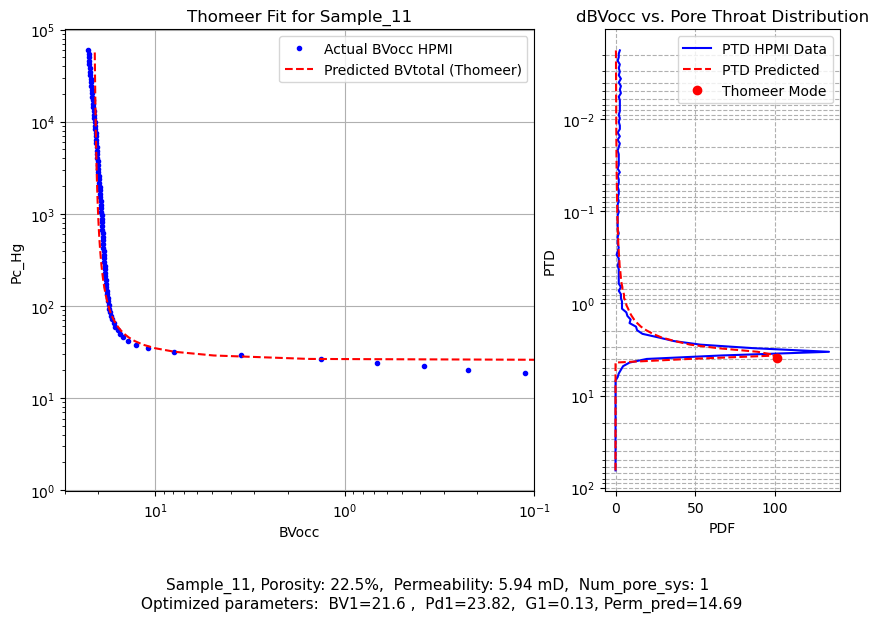

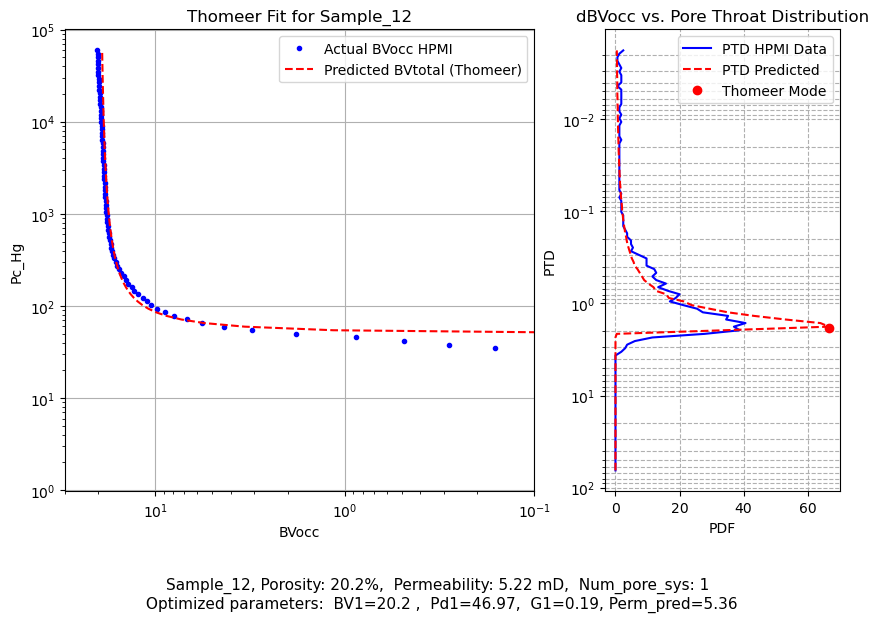

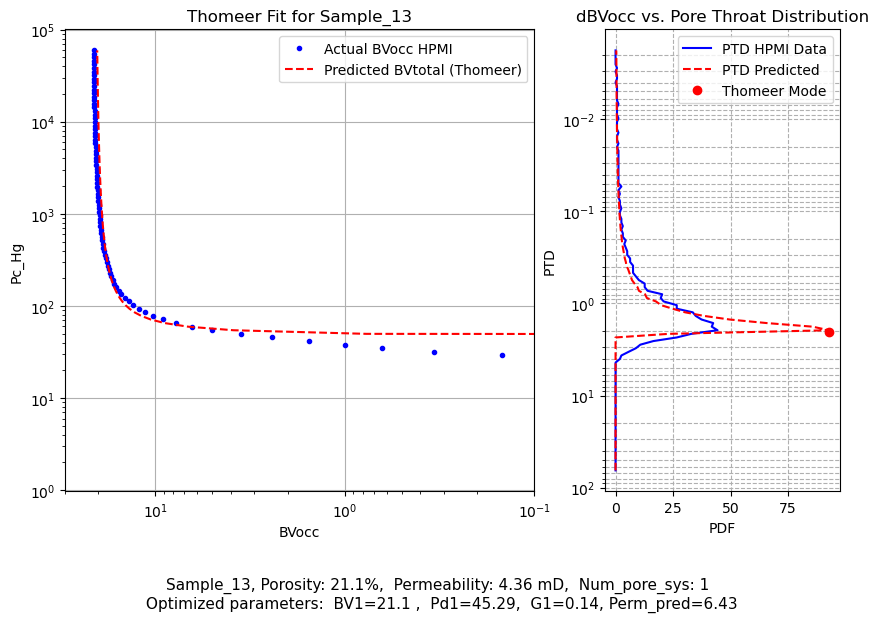

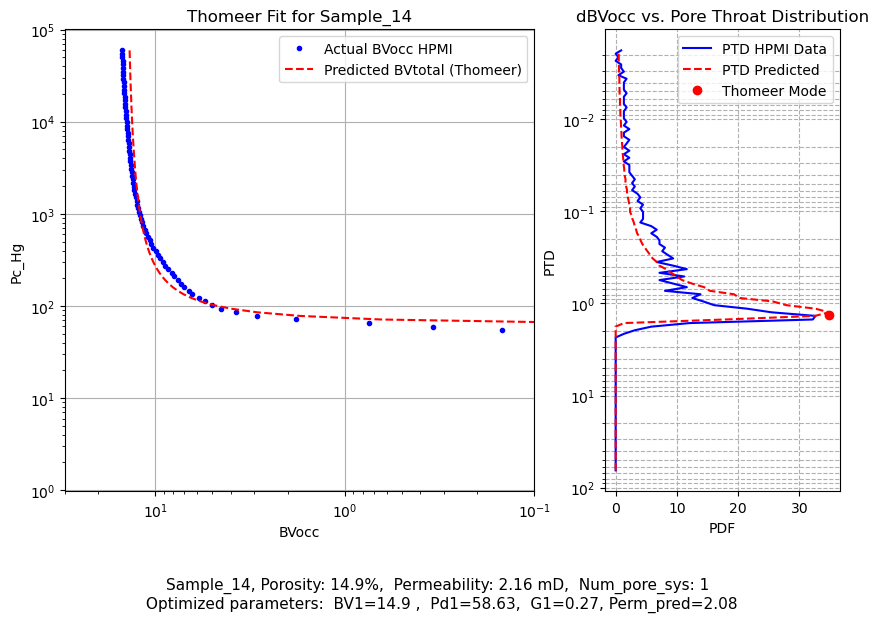

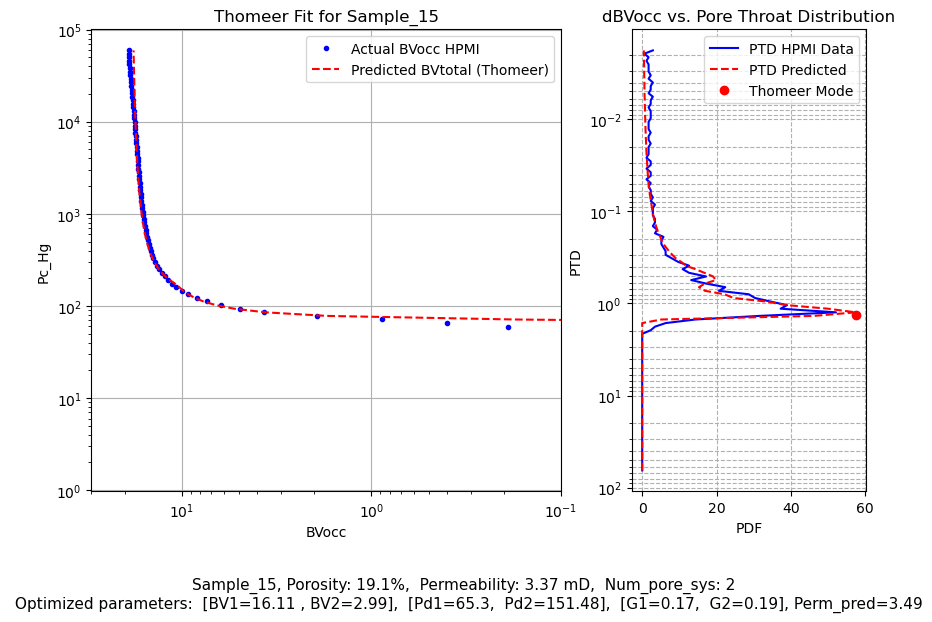

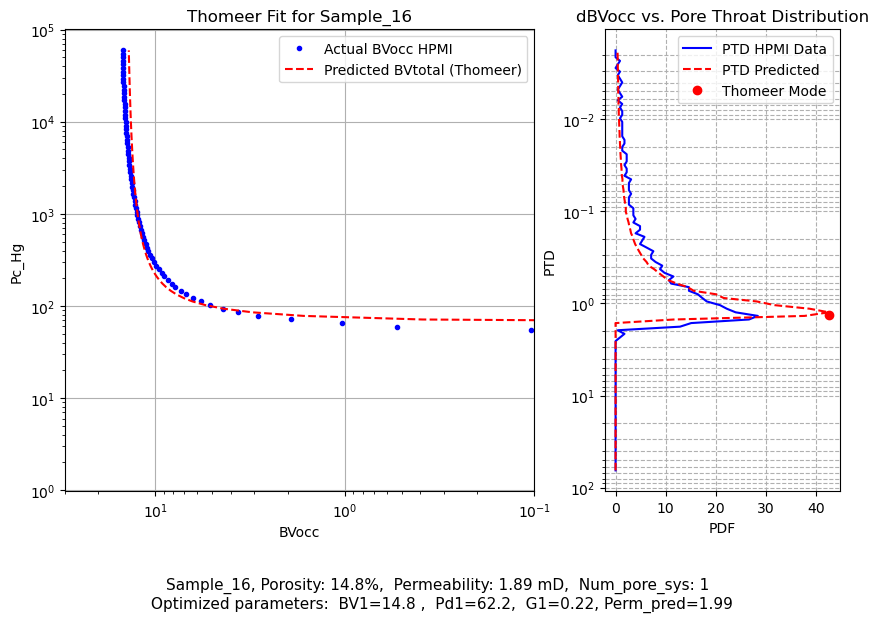

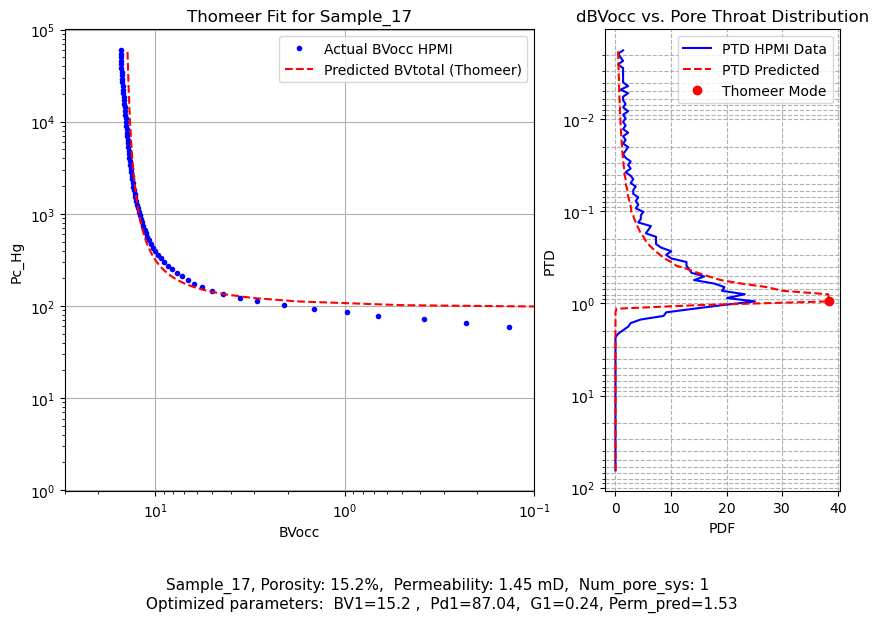

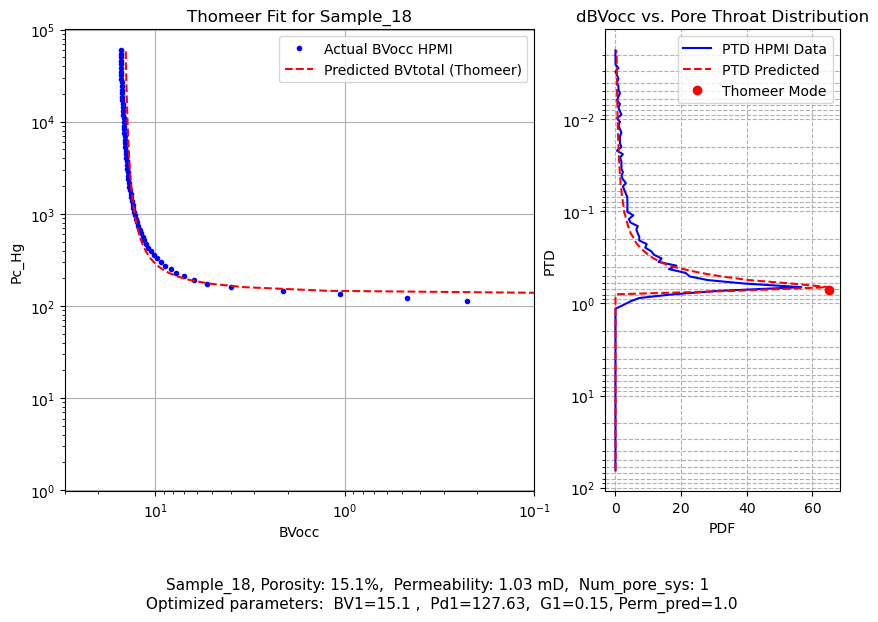

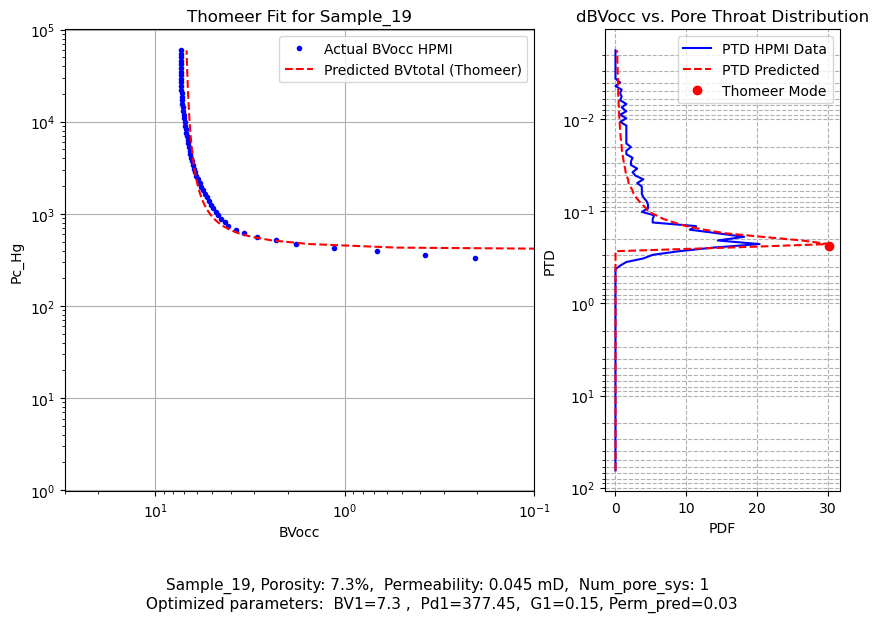

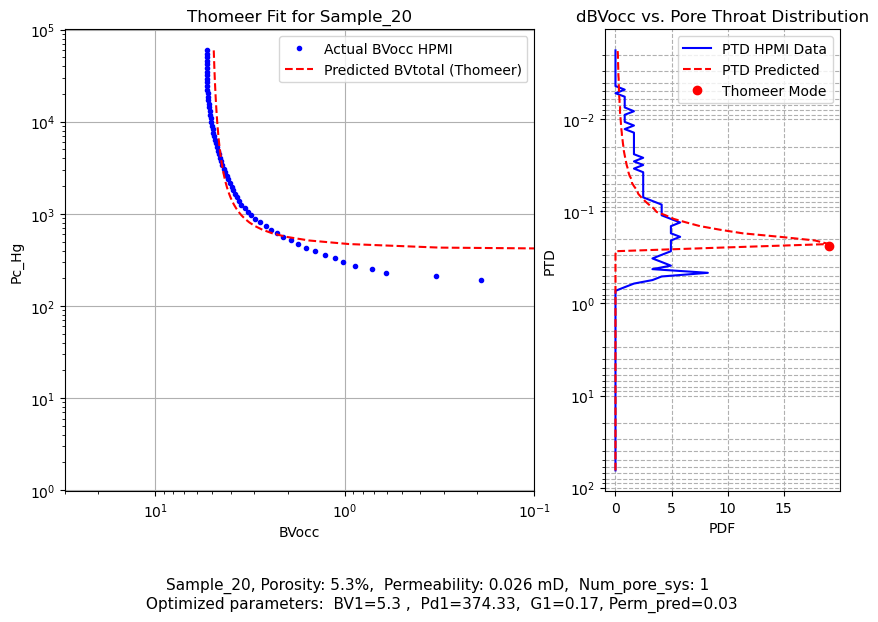

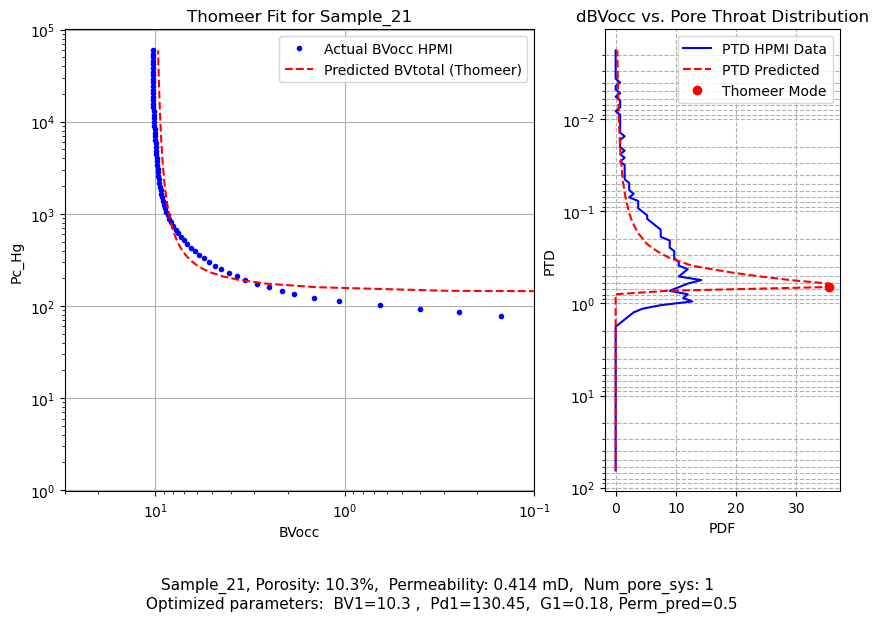

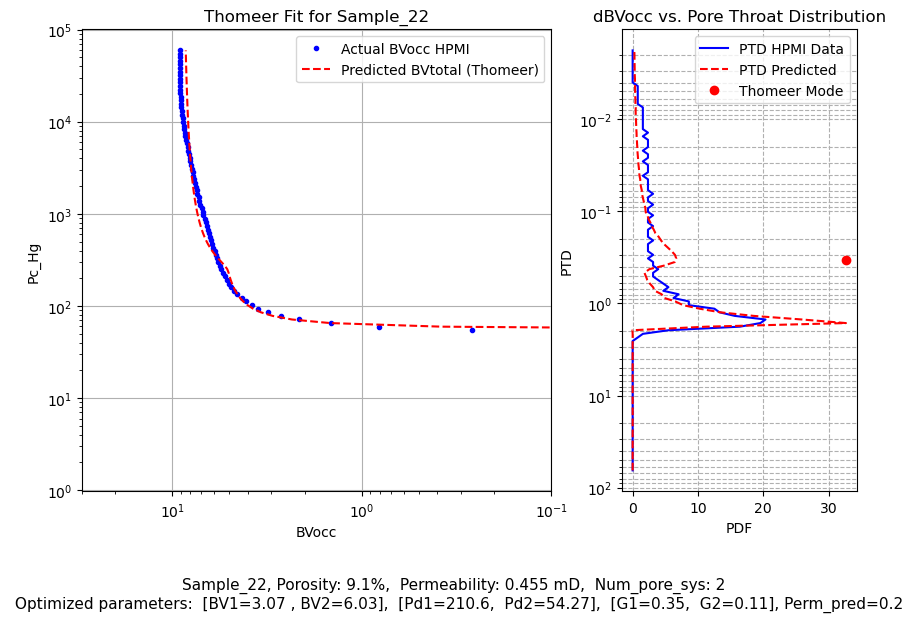

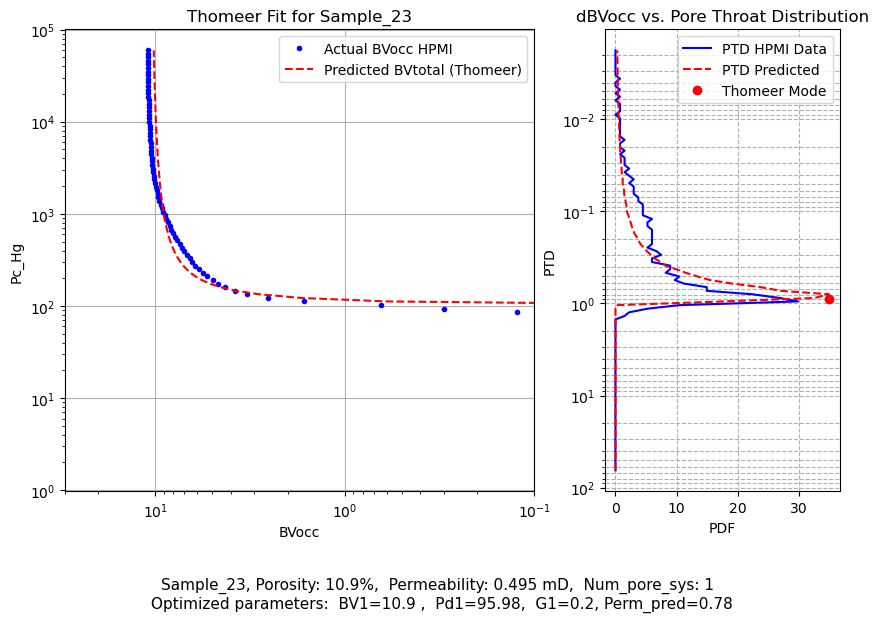

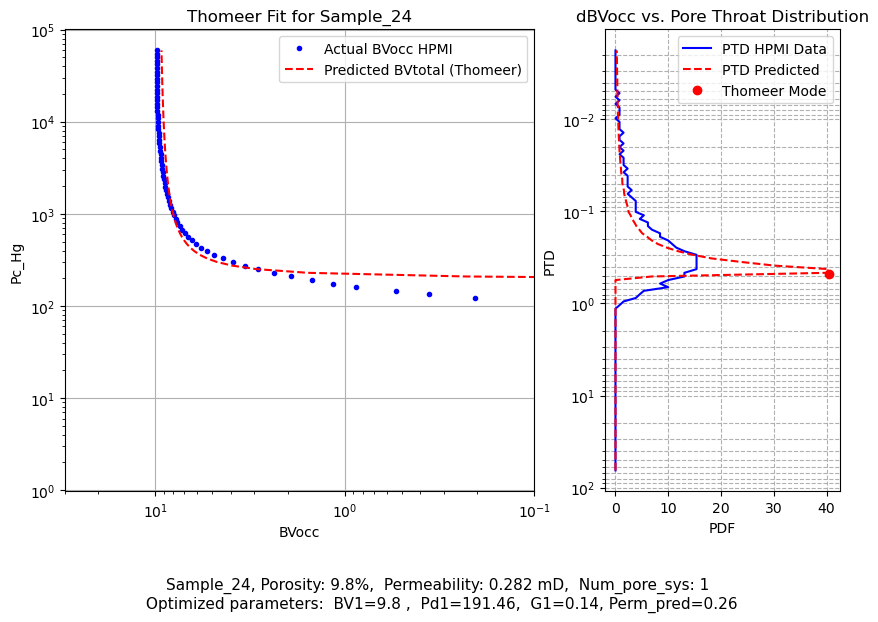

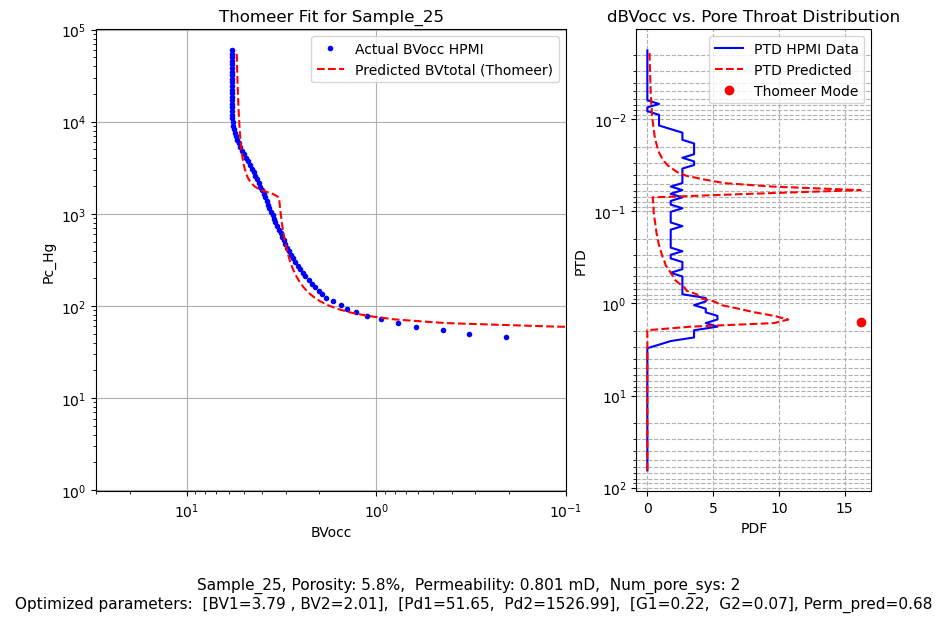

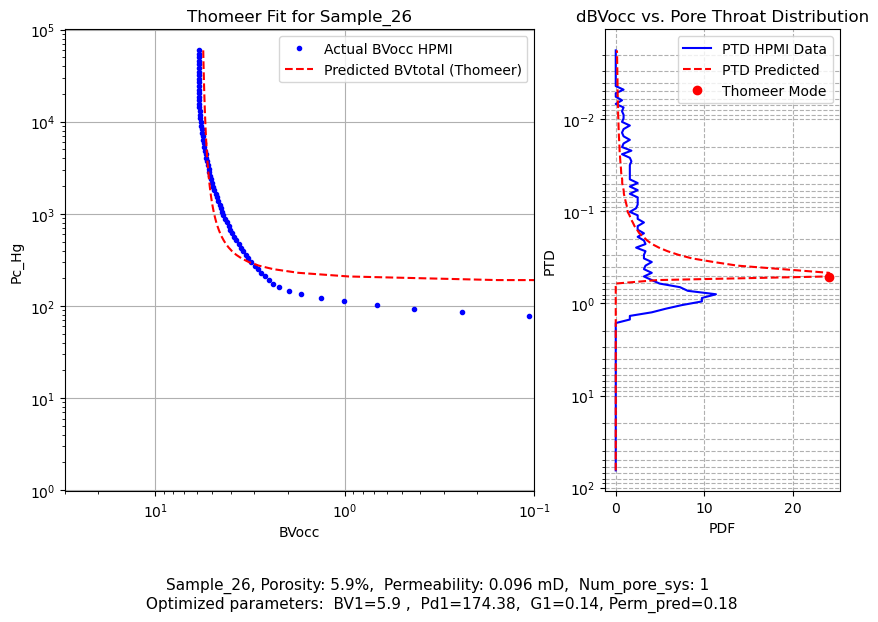

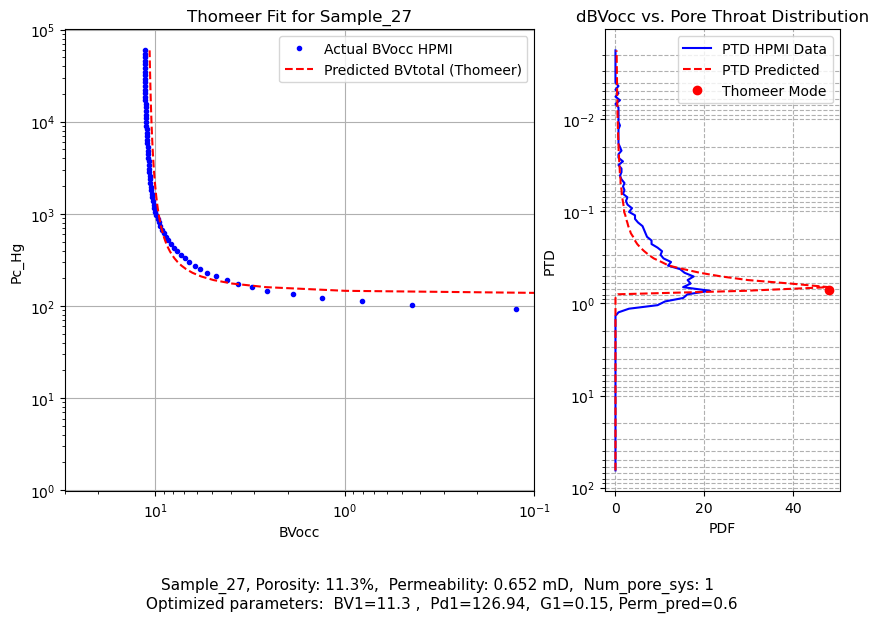

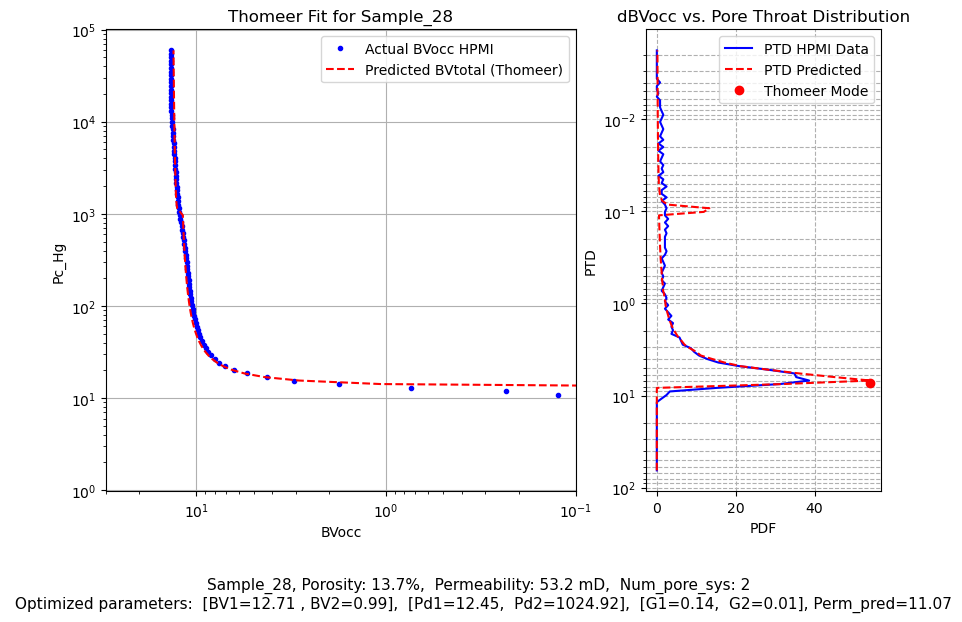

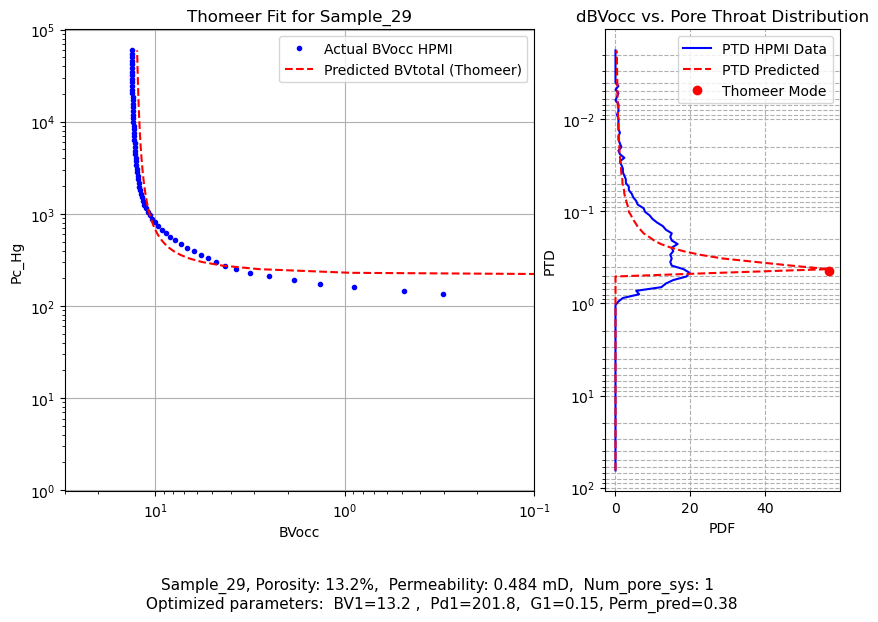

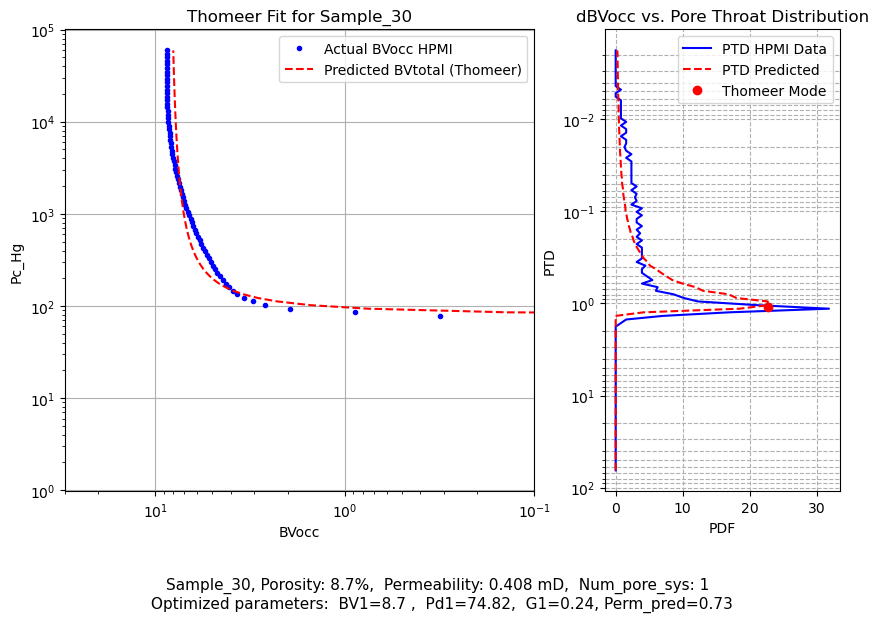

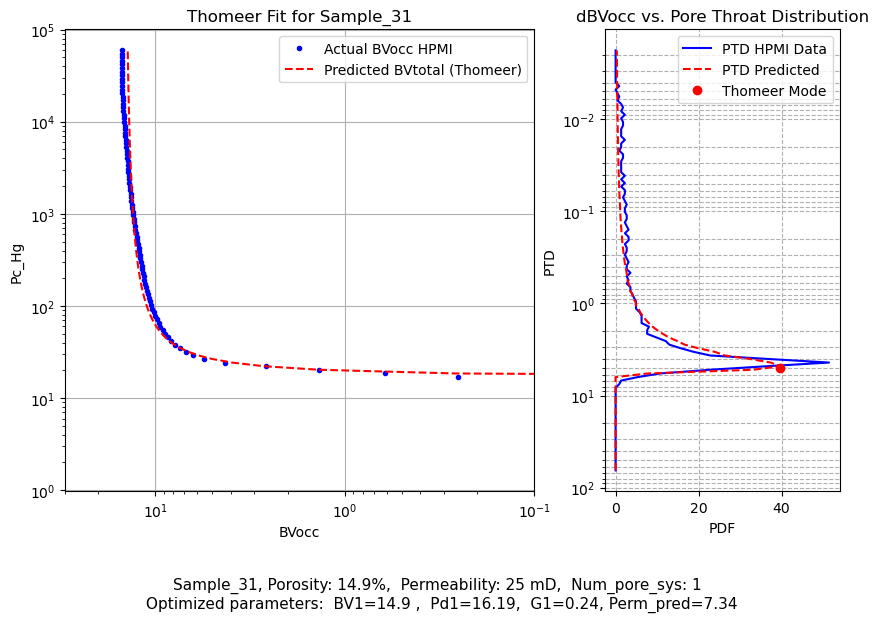

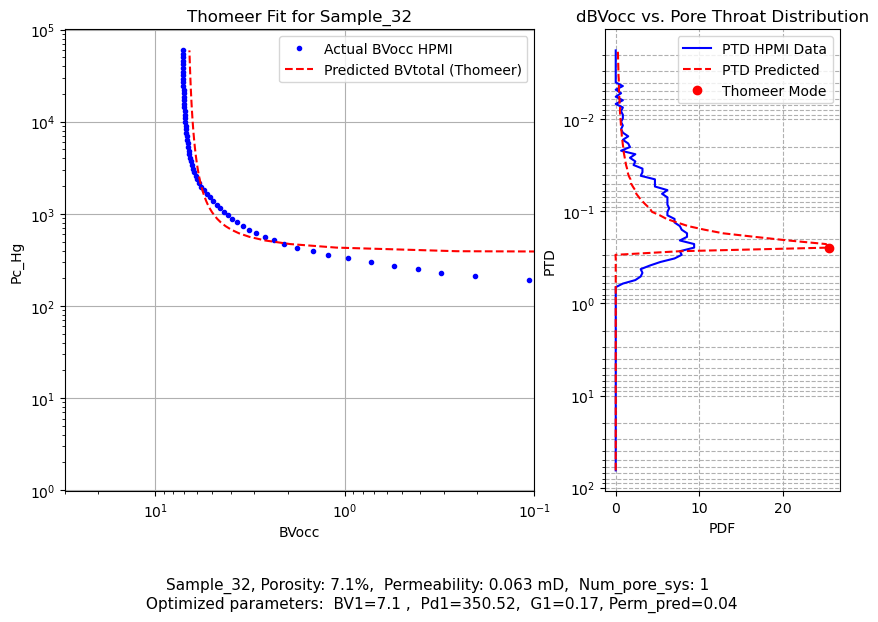

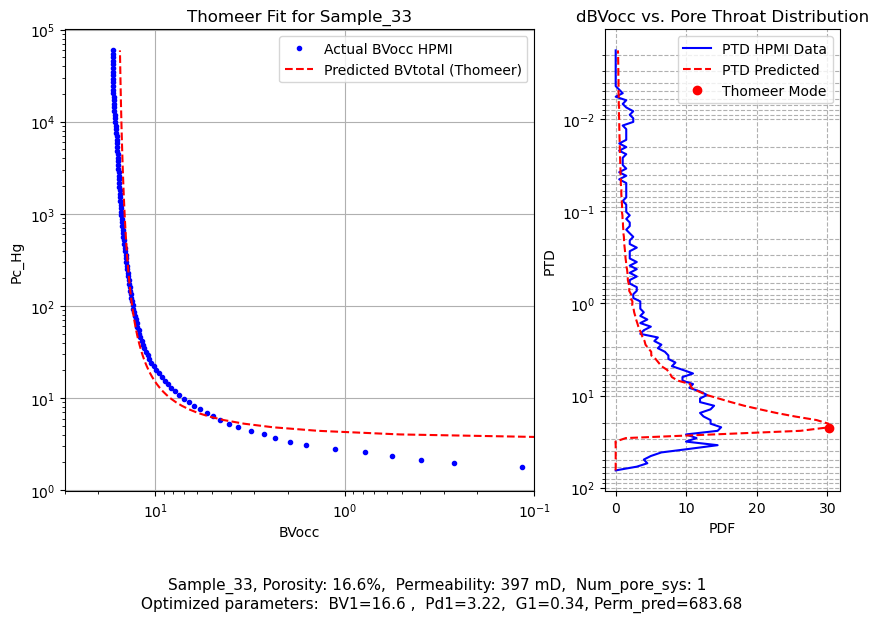

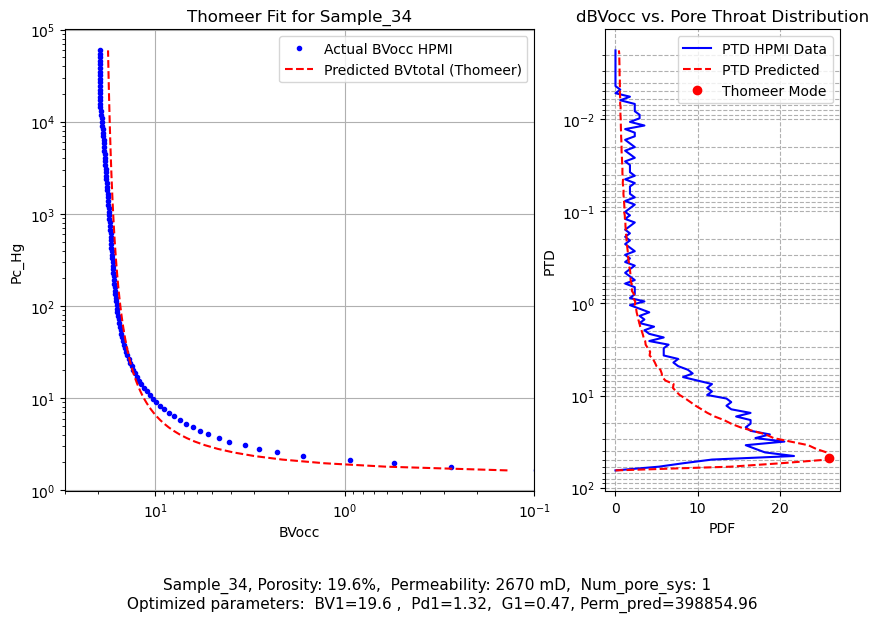

Bad result, optimization error is too high.


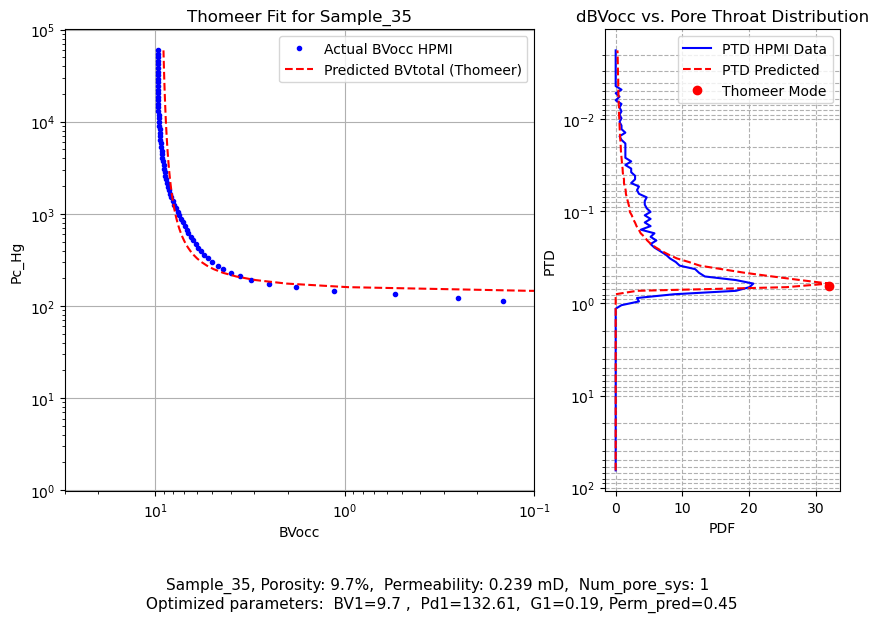

In [5]:
# This works pretty well

# Loop through all samples
for Sample in data_dict.keys():
    sample_data = data_dict[Sample]

    porosity_sample = sample_data['Porosity (%)']
    perm_sample = sample_data['Permeability']
    Num_pore_sys = sample_data['Num_pore_sys']

    Pc = sample_data['Pc']
    Sw = sample_data['Sw']
    BVocc = ((100 - Sw) / 100) * porosity_sample
    BVmax = np.max(BVocc)

    dBVocc = np.diff(BVocc)
    dBVocc = 30*np.insert(dBVocc,0,0)

    IFTheta = abs(480 * np.cos(np.radians(140)))  # Use the absolute value of IFTheta
    
    ############Rc = 2 * IFTheta * 0.147 / Pc
    Rc = (((2.0 * IFTheta) / (Pc * 69035.0)) * 10000.0)      # this is microns diamter per Clerke's spreadsheet
    #Rc =  (((2.0 * IFTheta) / (Pc * 69035.0)) * 10000.0) / 2  # this is microns radius


    
    ''' Dual Pore System Definitions '''''
    # Calculate BVtotal using Thomeer hyperbolic equations
    def model_function(BV1, G1, Pd1, G2, Pd2):
        
        BV2 = BVmax - BV1  # Calculate BV2 from BVtotal - BV1

        BVOCC1 = np.where(Pc >= Pd1, BV1 * 10 ** ((-0.434 * G1) / np.log10(Pc / Pd1)), 0.001)
        BVOCC2 = np.where(Pc >= Pd2, BV2 * 10 ** ((-0.434 * G2) / np.log10(Pc / Pd2)), 0.001)

        BV_total = BVOCC1 + BVOCC2
        return BV_total

   
    # Define the objective function
    def objective_function(params, Pc, BVocc):
        BV1, G1, Pd1, G2, Pd2 = params

        # Create an empty list for predicted values
        bvarray_pred = []

        # Loop through each Pc value to calculate BVOCC
        for Pc_value in Pc:
            
            BV2 = BVmax - BV1

            # Calculate BVOCC1 based on condition of Pc and Pd1
            if Pc_value >= Pd1:
                BVOCC1 = BV1 * 10**((-0.434 * G1) / np.log10(Pc_value / Pd1))
            else:
                BVOCC1 = 0.001  # Set to 0.001 when Pc < Pd1

            # Calculate BVOCC2 based on condition of Pc and Pd2
            if Pc_value >= Pd2:
                BVOCC2 = BV2 * 10**((-0.434 * G2) / np.log10(Pc_value / Pd2))
            else:
                BVOCC2 = 0.001  # Set to 0.001 when Pc < Pd2

            # Calculate total BVOCC
            BVOCC = BVOCC1 + BVOCC2

            # Ensure BVOCC does not exceed BVmax
            if BVOCC > BVmax:
                BVOCC = BVmax

            # Append the calculated value to the list
            bvarray_pred.append(BVOCC)

        # Calculate the mean squared error between actual and predicted BVocc
        error = np.mean((BVocc - bvarray_pred) ** 2)
        return error



    
    ''' Single Pore System Definitions '''
    def model_function1(BV1, G1, Pd1):
        
        #BV2 = BVmax - BV1  # Calculate BV2 from BVtotal - BV1
    
        BVOCC1 = np.where(Pc >= Pd1, BV1 * 10 ** ((-0.434 * G1) / np.log10(Pc / Pd1)), 0.001)
        #BVOCC2 = np.where(Pc >= Pd2, BV2 * 10 ** ((-0.434 * G2) / np.log10(Pc / Pd2)), 0.001)
    
        BV_total = BVOCC1
        return BV_total
    
    
    # Define the objective function
    def objective_function1(params, Pc, BVocc):
        BV1, G1, Pd1 = params

        # Create an empty list for predicted values
        bvarray_pred = []

        # Loop through each Pc value to calculate BVOCC
        for Pc_value in Pc:
            
            #BV2 = BVmax - BV1

            # Calculate BVOCC1 based on condition of Pc and Pd1
            if Pc_value >= Pd1:
                BVOCC1 = BV1 * 10**((-0.434 * G1) / np.log10(Pc_value / Pd1))
            else:
                BVOCC1 = 0.001  # Set to 0.001 when Pc < Pd1

            '''# Calculate BVOCC2 based on condition of Pc and Pd2
            if Pc_value >= Pd2:
                BVOCC2 = BV2 * 10**((-0.434 * G2) / np.log10(Pc_value / Pd2))
            else:
                BVOCC2 = 0.001  # Set to 0.001 when Pc < Pd2'''

            # Calculate total BVOCC
            BVOCC = BVOCC1

            # Ensure BVOCC does not exceed BVmax
            if BVOCC > BVmax:
                BVOCC = BVmax

            # Append the calculated value to the list
            bvarray_pred.append(BVOCC)

        # Calculate the mean squared error between actual and predicted BVocc
        error = np.mean((BVocc - bvarray_pred) ** 2)
        return error





    

    ''' if Dual Pore systems '''
    if Num_pore_sys == 2:

        #Perm = 10**(3.33 - 1.71 * log10(Pd1))
        #log10(Perm) = 3.33 - 1.71 * log10(Pd1)
        #(log10(Perm) - 3.33) = -1.71 * log10(Pd1)
        
        Pd1_calc =  10**((np.log10(perm_sample) - 3.33)/-1.71)
        
        # Initial guesses for the parameters (BV1, G1,   Pd1,       G2,   Pd2)
        initial_guess        = [np.max(BVocc)*0.7, 0.6,  Pd1_calc,  0.1,  200]
    
        # Define bounds for each parameter (keep them reasonable)
        bounds = [
            (0, np.max(BVocc)),  # BV1 bounds
            (0.01, 2),           # G1 bounds
            (Pd1_calc*0.5, Pd1_calc*1.5),            # Pd1 bounds
            (0.01, 2),           # G2 bounds
            (50, 60000)           # Pd2 bounds
        ]
    
        # Optimize the parameters using Powell method
        result = minimize(objective_function, initial_guess, args=(Pc, BVocc), method='Powell', bounds=bounds)
    
        # Extract optimized parameters
        BV1_opt, G1_opt, Pd1_opt, G2_opt, Pd2_opt = result.x
    
        # Print optimized parameters and minimized error
        minimized_error = result.fun
    
        '''print()
        print()
        print()
        #print('Pd1_calc=',round(Pd1_calc,2))
        print()
        #print(f"Optimized parameters for {Sample}: \n BV1={round(BV1_opt,2)}, BV2={round(BVmax - BV1_opt,2)}, G1={round(G1_opt,2)}, Pd1={round(Pd1_opt,2)}, G2={round(G2_opt,2)}, Pd2={round(Pd2_opt,2)}")
        #print(f"Optimized parameters for {Sample}: \n\n BV1={round(BV1_opt,2)}, , G1={round(G1_opt,2)}, Pd1={round(Pd1_opt,2)}, \n\n BV2={round(BVmax - BV1_opt,2)},    G2={round(G2_opt,2)}, Pd2={round(Pd2_opt,2)}")
        print()
        print(f"Final minimized error (MSE): {round(minimized_error,4)}")'''
    
        # Generate the final plot
        BV_total_pred = model_function(BV1_opt, G1_opt, Pd1_opt, G2_opt, Pd2_opt)
    
        dBV_total_pred = np.diff(BV_total_pred)
        dBV_total_pred = 30*np.insert(dBV_total_pred,0,0)
    
        Mode = np.exp(-1.15 * G1_opt)*(214/Pd1_opt)/2
        Perm_pred = 10**(-0.4839 + (0.1043 * Mode) + (0.0594 * porosity_sample) + (-0.0038 * Pd1_opt))
        
        
        def plot_micp_results(Pc, BVocc, BV_total_pred,BVmax,Rc):
    
            # Create the plot
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [2, 1]})
            
            ax1.plot(BVocc, Pc, 'bo', markersize=3, label='Actual BVocc HPMI')
            ax1.plot(BV_total_pred, Pc, 'r--', label='Predicted BVtotal (Thomeer)')
            ax1.set_xscale('log')
            ax1.set_yscale('log')
            ax1.set_xlim(30, 0.1)
            #ax.set_xscale('linear')
            ax1.set_xlabel('BVocc')
            ax1.set_ylabel('Pc_Hg')
            ax1.set_title(f'Thomeer Fit for {Sample}')
            ax1.grid(True)
            ax1.legend()
            
            # Add the text below the plot
            text_string = (f'{Sample}, Porosity: {porosity_sample}%, '
                           f' Permeability: {perm_sample} mD,  Num_pore_sys: {Num_pore_sys} \n '
                           f'Optimized parameters:  [BV1={round(BV1_opt,2)} , BV2={round(BVmax - BV1_opt,2)}],  '
                           f'[Pd1={round(Pd1_opt, 2)},  Pd2={round(Pd2_opt, 2)}],  '
                           f'[G1={round(G1_opt, 2)},  G2={round(G2_opt, 2)}], Perm_pred={round(Perm_pred,2)}')
    
            # Adjust the position of the text as needed
            plt.figtext(0.5, -0.08, text_string, ha="center", fontsize=11, wrap=True)
            
            
            # Plot PDF with reversed axes
            ax2.plot(dBVocc, Rc, 'b-', label='PTD HPMI Data')
            ax2.plot(dBV_total_pred, Rc, 'r--', label='PTD Predicted')
            ax2.plot(np.max(dBV_total_pred), Mode, 'ro', label='Thomeer Mode')
            ax2.set_xscale('linear')
            ax2.set_yscale('log')
            plt.gca().invert_yaxis()
            ax2.set_xlabel('PDF')
            ax2.set_ylabel('PTD')
            ax2.set_title('dBVocc vs. Pore Throat Distribution')
            ax2.grid(True, which="both", ls="--")
            ax2.legend()
    
            plt.show()
      
        plot_micp_results(Pc, BVocc, BV_total_pred, BVmax, Rc)
    
        # Optionally save the optimization results to an Excel file
        output_excel_file = 'Sample_Optimization_Results_Optimization_Method_Thomeer.xlsx'
    
        error_threshold = 1.0  # Define an appropriate threshold
    
        
        if minimized_error > error_threshold:
            print("Bad result, optimization error is too high.")
        else:
            #print("Good result, acceptable optimization error.")
    
            
            data_to_save = {
                'Sample': Sample,
                'Porosity (%)': porosity_sample,
                'Permeability (mD)': perm_sample,
                'Perm_predicted': Perm_pred,
                'BV1': round(BV1_opt, 2),
                'G1': round(G1_opt, 2),
                'Pd1': round(Pd1_opt, 2),
                'Mode': round(Mode,2),                               
                'BV2': round(BVmax - BV1_opt,2),
                'G2': round(G2_opt, 2),
                'Pd2': round(Pd2_opt, 2),
                'minimized_error': round(minimized_error, 6),
                'Num_pore_sys': Num_pore_sys,
            }
    
                  
            
            df = pd.DataFrame([data_to_save])
        
            # Check if the file already exists
            if os.path.exists(output_excel_file):
                with pd.ExcelWriter(output_excel_file, mode='a', if_sheet_exists='overlay', engine='openpyxl') as writer:
                    df.to_excel(writer, index=False, header=False, startrow=writer.sheets['Sheet1'].max_row)
            else:
                df.to_excel(output_excel_file, index=False)


            ''' else single pore system '''
    else:

        #Perm = 10**(3.33 - 1.71 * log10(Pd1))
        #log10(Perm) = 3.33 - 1.71 * log10(Pd1)
        #(log10(Perm) - 3.33) = -1.71 * log10(Pd1)
        
        Pd1_calc =  10**((np.log10(perm_sample) - 3.33)/-1.71)
        
        # Initial guesses for the parameters (BV1, G1,   Pd1,       G2,   Pd2)
        #initial_guess        = [np.max(BVocc)*0.7, 0.6,  Pd1_calc,  0.1,  200]
        initial_guess        = [np.max(BVocc), 0.6,  Pd1_calc]
    
        # Define bounds for each parameter (keep them reasonable)
        bounds = [
            (0, np.max(BVocc)),  # BV1 bounds
            (0.01, 2),           # G1 bounds
            (Pd1_calc*0.5, Pd1_calc*1.5),            # Pd1 bounds
            #(0.01, 2),           # G2 bounds
            #(50, 60000)           # Pd2 bounds
        ]
    
        # Optimize the parameters using Powell method
        result = minimize(objective_function1, initial_guess, args=(Pc, BVocc), method='Powell', bounds=bounds)
    
        # Extract optimized parameters
        BV1_opt, G1_opt, Pd1_opt = result.x
    
        # Print optimized parameters and minimized error
        minimized_error = result.fun
    
        '''print()
        print()
        print()
        #print('Pd1_calc=',round(Pd1_calc,2))
        print()
        #print(f"Optimized parameters for {Sample}: \n BV1={round(BV1_opt,2)}, BV2={round(BVmax - BV1_opt,2)}, G1={round(G1_opt,2)}, Pd1={round(Pd1_opt,2)}, G2={round(G2_opt,2)}, Pd2={round(Pd2_opt,2)}")
        #print(f"Optimized parameters for {Sample}: \n\n BV1={round(BV1_opt,2)}, , G1={round(G1_opt,2)}, Pd1={round(Pd1_opt,2)}, \n\n BV2={round(BVmax - BV1_opt,2)},    G2={round(G2_opt,2)}, Pd2={round(Pd2_opt,2)}")
        print()
        print(f"Final minimized error (MSE): {round(minimized_error,4)}")'''
    
        # Generate the final plot
        BV_total_pred = model_function1(BV1_opt, G1_opt, Pd1_opt)
    
        dBV_total_pred = np.diff(BV_total_pred)
        dBV_total_pred = 30*np.insert(dBV_total_pred,0,0)
    
        Mode = np.exp(-1.15 * G1_opt)*(214/Pd1_opt)/2
        Perm_pred = 10**( -0.4839 + (0.1043 * Mode) + (0.0594 * porosity_sample) + (-0.0038 * Pd1_opt))
        
        
        def plot_micp_results(Pc, BVocc, BV_total_pred,BVmax,Rc):
    
            # Create the plot
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [2, 1]})
            
            ax1.plot(BVocc, Pc, 'bo', markersize=3, label='Actual BVocc HPMI')
            ax1.plot(BV_total_pred, Pc, 'r--', label='Predicted BVtotal (Thomeer)')
            ax1.set_xscale('log')
            ax1.set_yscale('log')
            ax1.set_xlim(30, 0.1)
            #ax.set_xscale('linear')
            ax1.set_xlabel('BVocc')
            ax1.set_ylabel('Pc_Hg')
            ax1.set_title(f'Thomeer Fit for {Sample}')
            ax1.grid(True)
            ax1.legend()
            
            # Add the text below the plot
            text_string = (f'{Sample}, Porosity: {porosity_sample}%, '
                           f' Permeability: {perm_sample} mD,  Num_pore_sys: {1} \n '
                           f'Optimized parameters:  BV1={round(BV1_opt,2)} ,  '
                           f'Pd1={round(Pd1_opt, 2)},  '
                           f'G1={round(G1_opt, 2)}, Perm_pred={round(Perm_pred,2)}')
    
            # Adjust the position of the text as needed
            plt.figtext(0.5, -0.08, text_string, ha="center", fontsize=11, wrap=True)
            
            
            # Plot PDF with reversed axes
            ax2.plot(dBVocc, Rc, 'b-', label='PTD HPMI Data')
            ax2.plot(dBV_total_pred, Rc, 'r--', label='PTD Predicted')
            ax2.plot(np.max(dBV_total_pred), Mode, 'ro', label='Thomeer Mode')
            ax2.set_xscale('linear')
            ax2.set_yscale('log')
            plt.gca().invert_yaxis()
            ax2.set_xlabel('PDF')
            ax2.set_ylabel('PTD')
            ax2.set_title('dBVocc vs. Pore Throat Distribution')
            ax2.grid(True, which="both", ls="--")
            ax2.legend()
    
            plt.show()
      
        plot_micp_results(Pc, BVocc, BV_total_pred, BVmax, Rc)
    
        # Optionally save the optimization results to an Excel file
        output_excel_file = 'Sample_Optimization_Results_Optimization_Method_Thomeer.xlsx'
    
        error_threshold = 1.0  # Define an appropriate threshold

        
        if minimized_error > error_threshold:
            print("Bad result, optimization error is too high.")
        else:
            #print("Good result, acceptable optimization error.")
    
            
            data_to_save = {
                'Sample': Sample,
                'Porosity (%)': porosity_sample,
                'Permeability (mD)': perm_sample,
                'Perm_predicted': Perm_pred,
                'BV1': round(BV1_opt, 2),
                'G1': round(G1_opt, 2),
                'Pd1': round(Pd1_opt, 2),
                'Mode': round(Mode,2),                
                'BV2': 0.001,
                'G2': 0.001,
                'Pd2': 0.001,
                'minimized_error': round(minimized_error, 6),
                'Num_pore_sys': Num_pore_sys,
            }

      
            
            df = pd.DataFrame([data_to_save])
        
            # Check if the file already exists
            if os.path.exists(output_excel_file):
                with pd.ExcelWriter(output_excel_file, mode='a', if_sheet_exists='overlay', engine='openpyxl') as writer:
                    df.to_excel(writer, index=False, header=False, startrow=writer.sheets['Sheet1'].max_row)
            else:
                df.to_excel(output_excel_file, index=False)
    
            




# Load Data and run each sample in Automatic Mode:



In [6]:

# Specify the file path and sheet number
file_path = 'Sample_Optimization_Results_Optimization_Method_Thomeer.xlsx'

# Read the specific range from the sheet
df = pd.read_excel(file_path)

df.head()

Sample  Porosity (%)  Permeability (mD)  Perm_predicted    BV1    G1  \
0  Sample_2          14.5              41.40       40.940737  12.86  0.20   
1  Sample_3          14.5              41.40       30.037163  13.35  0.23   
2  Sample_4          13.9               6.88        6.821998  11.51  0.20   
3  Sample_5          13.9               6.88        7.401981  11.69  0.25   
4  Sample_6          12.1               3.00        2.928534  12.10  0.29   

     Pd1   Mode    BV2     G2       Pd2  minimized_error  Num_pore_sys  
0   7.06  12.10  1.640  0.380   199.360         0.373097             2  
1   7.55  10.82  1.150  0.010  1106.440         0.185122             2  
2  16.11   5.31  2.390  0.330   242.340         0.588161             2  
3  14.34   5.58  2.210  0.040   406.190         0.348518             2  
4  24.52   3.12  0.001  0.001     0.001         0.245655             1

In [7]:
# Assuming porosity and permeability data are stored in numpy arrays
porosity = df['Porosity (%)']
permeability = df['Permeability (mD)']  # Replace with actual permeability data
df['lperm'] = np.log10(df['Permeability (mD)'])  # Replace with actual permeability data
lperm = df['lperm']
BV1 = df['BV1']  # Replace with actual permeability data
G1 = df['G1']  # Replace with actual permeability data
Pd1 = df['Pd1']  # Replace with actual permeability data
BV2 = df['BV2']
G2 = df['G2']  # Replace with actual permeability data
Pd2 = df['Pd2']  # Replace with actual permeability data
Mode = np.exp(-1.15*G1)*(214/Pd1)/2

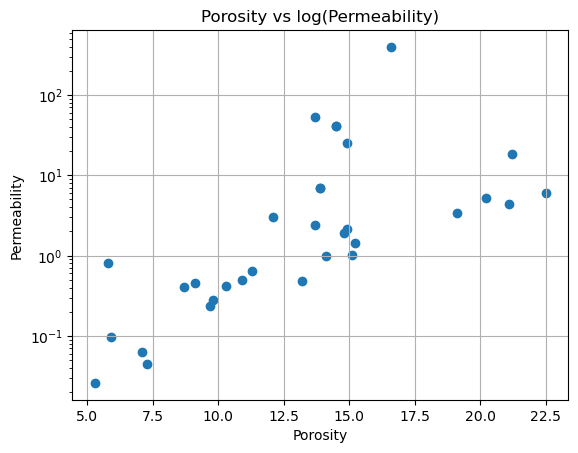

In [8]:
plt.scatter(porosity, permeability)
plt.xlabel('Porosity')
plt.ylabel('Permeability')
plt.title('Porosity vs log(Permeability)')
plt.yscale('log')
plt.grid()

plt.show()


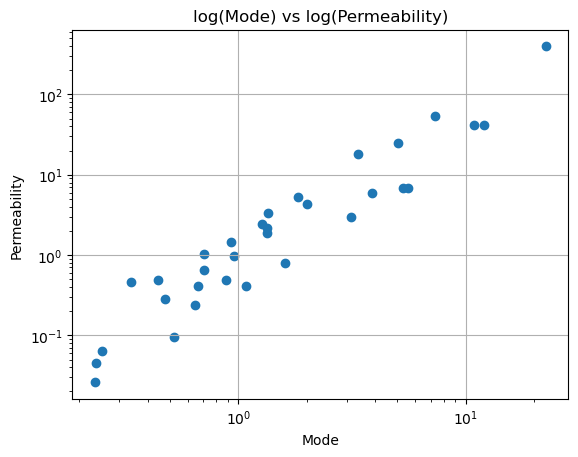

In [9]:
plt.scatter(Mode, permeability)
plt.xlabel('Mode')
plt.ylabel('Permeability')
plt.title('log(Mode) vs log(Permeability)')
plt.xscale('log')
plt.yscale('log')
plt.grid()

plt.show()


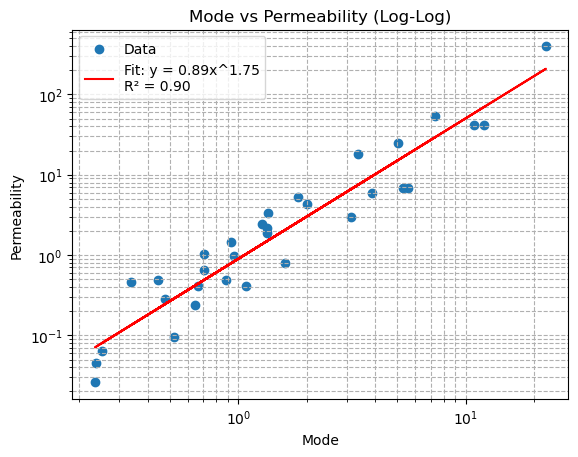

In [10]:
# Log-transform the data for linear regression
log_mu1 = np.log(Mode)
log_perm = np.log(permeability)

# Perform linear regression on the log-transformed data
slope, intercept = np.polyfit(log_mu1, log_perm, 1)

# Calculate the predicted values in log scale
log_perm_pred = slope * log_mu1 + intercept

# Convert the predicted log-permeability back to the original scale
perm_pred = np.exp(log_perm_pred)

# Calculate R² for the log-log regression
ss_res = np.sum((log_perm - log_perm_pred) ** 2)  # Residual sum of squares in log scale
ss_tot = np.sum((log_perm - np.mean(log_perm)) ** 2)  # Total sum of squares in log scale
r2 = 1 - (ss_res / ss_tot)

# Plot the scatter plot in log-log scale
plt.scatter(Mode, permeability, label='Data')

# Plot the regression line in the original scale
plt.plot(Mode, perm_pred, color='red', label=f'Fit: y = {np.exp(intercept):.2f}x^{slope:.2f}\nR² = {r2:.2f}')

# Add labels, title, and grid
plt.xlabel('Mode')
plt.ylabel('Permeability')
plt.title('Mode vs Permeability (Log-Log)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', ls='--')

# Add legend for the regression equation and R²
plt.legend()

# Show the plot
plt.show()



# Initial Perm Model: 

In [11]:
df.head()

Sample  Porosity (%)  Permeability (mD)  Perm_predicted    BV1    G1  \
0  Sample_2          14.5              41.40       40.940737  12.86  0.20   
1  Sample_3          14.5              41.40       30.037163  13.35  0.23   
2  Sample_4          13.9               6.88        6.821998  11.51  0.20   
3  Sample_5          13.9               6.88        7.401981  11.69  0.25   
4  Sample_6          12.1               3.00        2.928534  12.10  0.29   

     Pd1   Mode    BV2     G2       Pd2  minimized_error  Num_pore_sys  \
0   7.06  12.10  1.640  0.380   199.360         0.373097             2   
1   7.55  10.82  1.150  0.010  1106.440         0.185122             2   
2  16.11   5.31  2.390  0.330   242.340         0.588161             2   
3  14.34   5.58  2.210  0.040   406.190         0.348518             2   
4  24.52   3.12  0.001  0.001     0.001         0.245655             1   

      lperm  
0  1.617000  
1  1.617000  
2  0.837588  
3  0.837588  
4  0.477121

In [12]:
df['Mode'] = np.exp(-1.15*df['G1']) * (214/df['Pd1'])/2

In [13]:
import pandas as pd
import numpy as np

df = df.drop(columns=['Sample'])

# Calculate log10(Permeability)
df['logPerm'] = np.log10(df['Permeability (mD)'])

# Calculate the Pearson correlation matrix
correlation_matrix = df.corr()

# Display the correlations with logPerm
correlation_with_perm = correlation_matrix['logPerm']
print(correlation_with_perm)


Porosity (%)         0.694881
Permeability (mD)    0.569397
Perm_predicted       0.492762
BV1                  0.627996
G1                   0.231467
Pd1                 -0.838237
Mode                 0.799673
BV2                  0.142592
G2                   0.268512
Pd2                  0.323031
minimized_error      0.372682
Num_pore_sys         0.425429
lperm                1.000000
logPerm              1.000000
Name: logPerm, dtype: float64


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Select top features (replace with actual top features from correlation analysis)
X = df[['Mode', 'Porosity (%)', 'Pd1']]  # Example of top 3 features
y = df['logPerm']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform multiple linear regression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict on test set
y_pred = regressor.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R-squared: {r2}')
print(f'Mean Squared Error: {mse}')
print()

# Get the intercept and coefficients
intercept = regressor.intercept_
coefficients = regressor.coef_

print(intercept, coefficients)

# Print the equation
print("Linear Regression Equation: ")
print(f"y = {intercept:.4f} + ", end="")
for i, col in enumerate(X.columns):
    print(f"({coefficients[i]:.4f} * {col})", end=" + " if i < len(coefficients) - 1 else "\n")


R-squared: 0.9057836006710744
Mean Squared Error: 0.15711424074779037

-0.7298596975733752 [ 0.13716878  0.06955259 -0.00311591]
Linear Regression Equation: 
y = -0.7299 + (0.1372 * Mode) + (0.0696 * Porosity (%)) + (-0.0031 * Pd1)


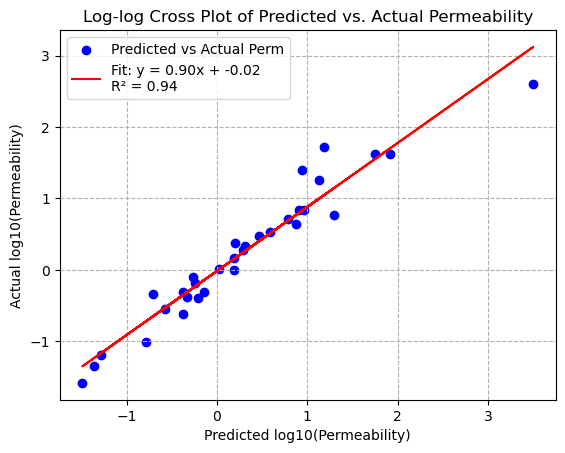

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Log-transform the data for linear regression
#log_perm_pred = -0.4839 + (0.1043 * df['Mode']) + (0.0594 * df['Porosity (%)']) + (-0.0038 * df['Pd1'])
log_perm_pred  = -0.7299 + (0.1372 * df['Mode']) + (0.0696 * df['Porosity (%)']) + (-0.0031 * df['Pd1'])


log_perm = np.log10(permeability)

# Perform linear regression on the log-transformed data
slope, intercept = np.polyfit(log_perm_pred, log_perm, 1)

# Calculate the regression line values based on the log-perm predictions
log_perm_fit = slope * log_perm_pred + intercept

# Calculate R² for the log-log regression
ss_res = np.sum((log_perm - log_perm_fit) ** 2)  # Residual sum of squares
ss_tot = np.sum((log_perm - np.mean(log_perm)) ** 2)  # Total sum of squares
r2 = 1 - (ss_res / ss_tot)

# Plot the scatter plot in log-log scale (log_perm_pred vs. log_perm)
plt.scatter(log_perm_pred, log_perm, label='Predicted vs Actual Perm', color='blue')

# Plot the regression line
plt.plot(log_perm_pred, log_perm_fit, color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}\nR² = {r2:.2f}')

# Add labels, title, and grid
plt.xlabel('Predicted log10(Permeability)')
plt.ylabel('Actual log10(Permeability)')
plt.title('Log-log Cross Plot of Predicted vs. Actual Permeability')
plt.grid(True, which='both', ls='--')

# Add legend for the regression equation and R²
plt.legend()

# Show the plot
plt.show()
